In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import numpy as np
import pandas as pd

In [14]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
# import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, Query
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite",echo=False)

#### Inspect the dataBase

In [6]:
# inspect DataBase
inspect_db = inspect(engine)
inspect_db.get_table_names()

['measurement', 'station']

In [7]:
# get columns names
mea_col = inspect_db.get_columns('measurement')
sta_col = inspect_db.get_columns('station')
print("--------measurement table-------")
[print(c['name'],c['type']) for c in mea_col];
print("--------station table-------")
[print(c['name'],c['type']) for c in sta_col];

--------measurement table-------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------station table-------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

# Exploratory Climate Analysis

#### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [15]:
# find the latest date
all_date_data = (
                Query(Measurement)
                # .filter(Measurement.date > 2016)
                .with_session(session)
                .with_entities(Measurement.date)
                .all()
                )
lastest_date = all_date_data[len(all_date_data)-1].date
lastest_date

# find 12 months from the latest date
twl_mon_ago = dt.datetime.strptime(lastest_date, '%Y-%m-%d') - dt.timedelta(days=365)
twl_mon_ago

datetime.datetime(2016, 8, 23, 0, 0)

In [16]:
# 12 months of Precipretation Data
prcp_data = (
                Query(Measurement)
                .filter(Measurement.date >= twl_mon_ago, Measurement.prcp !=None)
                .with_session(session)
                .with_entities(Measurement.date, Measurement.prcp)
                .order_by(Measurement.date)
                .all()
                )
prcp_data[:10]

[('2016-08-24', 0.08),
 ('2016-08-24', 2.15),
 ('2016-08-24', 2.28),
 ('2016-08-24', 1.22),
 ('2016-08-24', 2.15),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-25', 0.0),
 ('2016-08-25', 0.0)]

In [18]:
#  12 Months of Precipretation Data average by Date since there are repeating data
prcp_data = session.query(Measurement.date, func.avg(Measurement.prcp))\
    .filter(Measurement.date >= twl_mon_ago, Measurement.prcp !=None)\
        .group_by(Measurement.date).all()
prcp_data[:10]

[('2016-08-24', 1.5549999999999997),
 ('2016-08-25', 0.07714285714285715),
 ('2016-08-26', 0.016666666666666666),
 ('2016-08-27', 0.06399999999999999),
 ('2016-08-28', 0.5166666666666666),
 ('2016-08-29', 0.24333333333333332),
 ('2016-08-30', 0.011666666666666667),
 ('2016-08-31', 0.6359999999999999),
 ('2016-09-01', 0.006),
 ('2016-09-02', 0.05)]

In [19]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df_prcp = pd.DataFrame(prcp_data, columns=['Date', 'Precipitation']).sort_values(by=['Date'], ascending=True)
df_prcp.set_index('Date', inplace=True)
df_prcp.head()

,Precipitation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


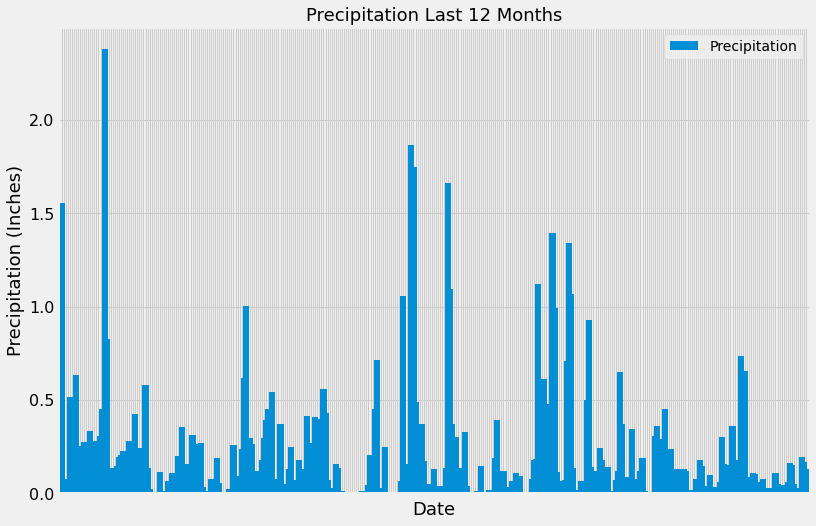

In [20]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = df_prcp.plot(kind='bar', width=3, figsize=(12,8))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.tick_params(axis='y', labelsize=16)
plt.title("Precipitation Last 12 Months", size=18)
plt.ylabel("Precipitation (Inches)", size=18)
plt.xlabel("Date", size=18)
plt.savefig("Imanges/Precipitation.png")

In [21]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp_new = df_prcp.copy()
df_prcp_new.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Station Analysis

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_act_station = (
                    Query(Measurement)
                    .with_session(session)
                    .with_entities(Measurement.station, func.count(Measurement.station))
                    .group_by(Measurement.station)
                    .order_by(func.count(Measurement.station).desc())
                    .all()
)
most_act_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_sta_id = most_act_station[0][0]


top_sta_temp = (
                    Query(Measurement)
                    .with_session(session)
                    .filter(Measurement.station == top_sta_id)
                    .with_entities(func.min(Measurement.tobs), func.max(Measurement.tobs), 
                    func.avg(Measurement.tobs))
                    .all()
)

top_sta_temp

[(54.0, 85.0, 71.66378066378067)]

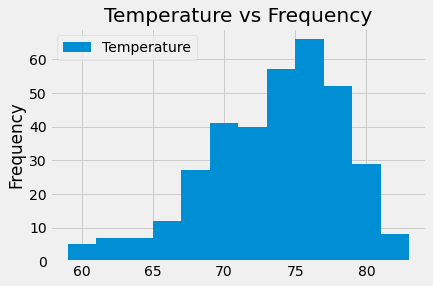

In [24]:
# Choose the station with the highest number of temperature observations.
top_sta_id = most_act_station[0][0]

tobs_12 = (
                    Query(Measurement)
                    .with_session(session)
                    .filter(Measurement.station == top_sta_id, Measurement.date >= twl_mon_ago)
                   .with_entities(Measurement.tobs)
                    .all()
)
df_tobs_12 = pd.DataFrame(tobs_12, columns=['Temperature'])
# histogram plot with bins=12 for 12 mounths.
df_tobs_12.plot.hist(bins=12, title="Temperature vs Frequency")
plt.savefig("Imanges/TempVsFreq.png");